In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
import scipy
from scipy.stats import poisson, binom, beta
from scipy.optimize import minimize
from scipy.optimize import minimize, NonlinearConstraint

### 1st step - Possession

$$
P^h \sim Beta(\alpha, \alpha Z(K^h))
$$

The function $Z$ is a transformation to make the distribution "symmetryc", i.e. $E[P^h|k] = 1 - E[P^h|-k]$

$$
Z(x) = \frac{1}{\frac{1}{2} (1 + \tanh(cx))}-1
$$

$$
K^h = \Gamma^h + \Gamma^{HA} - \Gamma^a
$$



In [84]:
data = pd.read_csv('3_step_data.csv', sep=',')

In [85]:
data

,home,away,home_goal,away_goal,home_shots,away_shots,home_possession,away_possession
0,Manchester United,Leicester City,2,1,8,8,0.46,0.54
1,Newcastle United,Tottenham Hotspur,1,2,11,13,0.40,0.60
2,AFC Bournemouth,Cardiff City,2,0,11,7,0.62,0.38
3,Fulham,Crystal Palace,0,2,11,11,0.66,0.34
4,Huddersfield Town,Chelsea,0,3,6,8,0.37,0.63
...,...,...,...,...,...,...,...,...
375,Liverpool,Wolverhampton Wanderers,2,0,11,7,0.59,0.41
376,Manchester United,Cardiff City,0,2,21,11,0.73,0.27
377,Southampton,Huddersfield Town,1,1,7,8,0.53,0.47
378,Tottenham Hotspur,Everton,2,2,9,13,0.55,0.45


In [86]:
teams = pd.unique(data[['home', 'away']].values.ravel('K'))
teams_params = pd.DataFrame({
    'Team': teams,
    'gamma': 1,
    'alpha': 10,
    'beta': 3,
    'delta':0.8,
    'zeta': 0.2
})

teams_params.set_index('Team', inplace=True)

In [87]:
hyper_params = {
    'gamma_ha': 0.5,
    'beta_dist_alpha': 6,
    'c': 0.01,
    'alpha_ha':1
}

In [88]:
teams_params

,gamma,alpha,beta,delta,zeta
Team,,,,,
Manchester United,1,10,3,0.8,0.2
Newcastle United,1,10,3,0.8,0.2
AFC Bournemouth,1,10,3,0.8,0.2
Fulham,1,10,3,0.8,0.2
Huddersfield Town,1,10,3,0.8,0.2
Watford,1,10,3,0.8,0.2
Wolverhampton Wanderers,1,10,3,0.8,0.2
Liverpool,1,10,3,0.8,0.2
Southampton,1,10,3,0.8,0.2


In [89]:
hyper_params

{'gamma_ha': 0.5, 'beta_dist_alpha': 6, 'c': 0.01, 'alpha_ha': 1}

In [90]:
n_train = 150
n_validation = 200

data_train = data[:n_train]
data_validation = data[n_train:n_validation]
data_test = data[n_validation:]


In [91]:
def Z_func(x, c):
    return (1/(0.5*(1+np.tanh(x*c))))-1

In [92]:
def poss_log_likelihood(params, data, team=None):

    gamma_ha = params[-3]
    beta_dist_alpha = params[-2]
    c = params[-1]
    params = params[:-3]


    teams_params = pd.DataFrame({
        'Team': team,
        'gamma': params}).set_index('Team')
    
    total_sum = 0


    
    for _, row in data.iterrows():
        name_h = row['home']
        name_a = row['away']
        home_poss = row['home_possession']
        away_poss = row['away_possession']

        
        gamma_h = teams_params.at[name_h, 'gamma']
        gamma_a = teams_params.at[name_a, 'gamma']
        
        kh = gamma_h + gamma_ha - gamma_a
        z = Z_func(kh, c)
        

        row_sum = scipy.stats.beta.logpdf(home_poss, beta_dist_alpha, beta_dist_alpha*z)
        total_sum += row_sum
    
    return -total_sum.tolist()

In [93]:
# Initial guess
initial_params = teams_params.gamma.values.T.flatten().tolist() + [hyper_params['gamma_ha'], hyper_params['beta_dist_alpha'], hyper_params['c']]  # Flatten alpha and beta, and add initial gamma

In [94]:
poss_log_likelihood(initial_params, data_train, teams_params.index.tolist())

-87.74492497874844

In [95]:
# Bounds for
gamma1, gamma2 = 0.0, 20.0
gammaha1, gammaha2 = 0.0, 5.0
bda1, bda2 = 1.0, 50.0 
c1, c2 = 0.0, 0.3  
bounds = [(gamma1, gamma2)] * len(teams) + [(gammaha1, gammaha2)] + [(bda1, bda2)] + [(c1, c2)]


# Optimize
result = minimize(poss_log_likelihood, initial_params, args=(data_train, teams), bounds=bounds, options={'maxiter': 100}) #, constraints=constraints)

In [96]:
optimized_params = result.x
optimized_gamma_ha = optimized_params[-3]
optimized_beta_dist_alpha = optimized_params[-2]
optimized_c = optimized_params[-1]
optimized_gammas = optimized_params[:len(teams)]

In [97]:
hyper_params['gamma_ha'] = optimized_gamma_ha
hyper_params['beta_dist_alpha'] = optimized_beta_dist_alpha
hyper_params['c'] = optimized_c
teams_params.gamma = optimized_gammas

In [98]:
hyper_params

{'gamma_ha': np.float64(0.6168457201052128),
 'beta_dist_alpha': np.float64(23.86471879886326),
 'c': np.float64(0.048118198048547),
 'alpha_ha': 1}

In [99]:
teams_params

,gamma,alpha,beta,delta,zeta
Team,,,,,
Manchester United,6.419870,10,3,0.8,0.2
Newcastle United,0.362986,10,3,0.8,0.2
AFC Bournemouth,3.497677,10,3,0.8,0.2
Fulham,4.906879,10,3,0.8,0.2
Huddersfield Town,4.606368,10,3,0.8,0.2
Watford,2.640584,10,3,0.8,0.2
Wolverhampton Wanderers,2.875035,10,3,0.8,0.2
Liverpool,8.776290,10,3,0.8,0.2
Southampton,3.285736,10,3,0.8,0.2


In [100]:
def shot_log_likelihood(params, data, team=None):

    alpha_ha = params[-1]
    params = params[:-1]


    teams_params = pd.DataFrame({
        'Team': team,
        'alpha': params[:len(team)],
        'beta': params[len(team):]}).set_index('Team')
    
    total_sum = 0


    
    for _, row in data.iterrows():
        name_h = row['home']
        name_a = row['away']
        home_poss = row['home_possession']
        away_poss = row['away_possession']
        home_shots = row['home_shots']
        away_shots = row['away_shots']

        
        alpha_h = teams_params.at[name_h, 'alpha']
        beta_h = teams_params.at[name_h, 'beta']

        alpha_a = teams_params.at[name_a, 'alpha']
        beta_a = teams_params.at[name_a, 'beta']
        
        lambda_h = alpha_ha + alpha_h - beta_a
        lambda_a = alpha_a - beta_h


        row_sum = poisson.logpmf(home_shots, lambda_h*home_poss) + poisson.logpmf(away_shots, lambda_a*away_poss) 
        total_sum += row_sum
    
    return -total_sum.tolist()

In [101]:
# Initial guess
initial_params = teams_params[['alpha', 'beta']].values.T.flatten().tolist() + [hyper_params['alpha_ha']]  # Flatten alpha and beta, and add initial gamma

In [102]:
teams_params

,gamma,alpha,beta,delta,zeta
Team,,,,,
Manchester United,6.419870,10,3,0.8,0.2
Newcastle United,0.362986,10,3,0.8,0.2
AFC Bournemouth,3.497677,10,3,0.8,0.2
Fulham,4.906879,10,3,0.8,0.2
Huddersfield Town,4.606368,10,3,0.8,0.2
Watford,2.640584,10,3,0.8,0.2
Wolverhampton Wanderers,2.875035,10,3,0.8,0.2
Liverpool,8.776290,10,3,0.8,0.2
Southampton,3.285736,10,3,0.8,0.2


In [103]:
shot_log_likelihood(initial_params, data_train, teams_params.index.tolist())

1996.6103014222062

In [104]:
# Define the constraint functions for a_i > b_j for all i, j
def constraint(params):
    n = int((len(params)-1)/2)
    a = params[:n]
    b = params[n:2*n]
    c = params[-1]
    constraints = []
    for ai in a:
        for bj in b:
            constraints.append(ai - bj)
    return constraints

constraints = {
    'type': 'ineq',  # 'ineq' means the constraint function should be non-negative
    'fun': lambda params: np.array(constraint(params))
}

In [105]:
# Bounds for alpha, beta, and home adv alpha
a1, a2 = 0, 30.0  # Bounds for alpha
b1, b2 = 0.0, 10.0  # Bounds for beta
c1, c2 = 0.0, 10.0  # Bounds for gamma
bounds = [(a1, a2)] * len(teams) + [(b1, b2)] * len(teams) + [(c1, c2)]



# Optimize
result = minimize(shot_log_likelihood, initial_params, args=(data_train, teams), bounds=bounds, constraints=constraints, options={'maxiter': 100})

In [106]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 738.1505297223844
       x: [ 2.371e+01  2.708e+01 ...  8.722e+00  2.753e+00]
     nit: 26
     jac: [ 8.392e-05 -1.144e-04 ... -3.815e-05  8.621e-04]
    nfev: 1093
    njev: 26

In [107]:
optimized_params = result.x
optimized_alpha_ha = optimized_params[-1]
optimized_alphas = optimized_params[:len(teams)]
optimized_betas = optimized_params[len(teams):2*len(teams)]

In [108]:
hyper_params['alpha_ha'] = optimized_alpha_ha
teams_params.alpha = optimized_alphas
teams_params.beta = optimized_betas

In [109]:
teams_params

,gamma,alpha,beta,delta,zeta
Team,,,,,
Manchester United,6.419870,23.712108,3.876058,0.8,0.2
Newcastle United,0.362986,27.076319,7.035955,0.8,0.2
AFC Bournemouth,3.497677,25.023999,5.525066,0.8,0.2
Fulham,4.906879,25.845727,1.421693,0.8,0.2
Huddersfield Town,4.606368,24.347253,7.442669,0.8,0.2
Watford,2.640584,24.761419,9.277963,0.8,0.2
Wolverhampton Wanderers,2.875035,30.000000,8.966972,0.8,0.2
Liverpool,8.776290,24.732092,9.055194,0.8,0.2
Southampton,3.285736,29.766929,7.106571,0.8,0.2


In [110]:
hyper_params

{'gamma_ha': np.float64(0.6168457201052128),
 'beta_dist_alpha': np.float64(23.86471879886326),
 'c': np.float64(0.048118198048547),
 'alpha_ha': np.float64(2.7527440287281153)}

In [154]:
def goal_log_likelihood(params, data, team=None):


    teams_params = pd.DataFrame({
        'Team': team,
        'delta': params[:len(team)],
        'zeta': params[len(team):]}).set_index('Team')
    
    total_sum = 0


    
    for _, row in data.iterrows():
        name_h = row['home']
        name_a = row['away']
        home_shots = row['home_shots']
        away_shots = row['away_shots']
        home_goal = row['home_goal']
        away_goal = row['away_goal']

        
        delta_h = teams_params.at[name_h, 'delta']
        zeta_h = teams_params.at[name_h, 'zeta']

        delta_a = teams_params.at[name_a, 'delta']
        zeta_a = teams_params.at[name_a, 'zeta']
        
        pg_h = delta_h - zeta_a
        pg_a = delta_a - zeta_h

        
        row_sum = binom.logpmf(home_goal, home_shots, pg_h) + binom.logpmf(away_goal, away_shots, pg_a)
        total_sum += row_sum
    
    return -total_sum.tolist()

In [155]:
def goal_log_likelihood(params, data, team=None):


    teams_params = pd.DataFrame({
        'Team': team,
        'delta': params[:len(team)],
        'zeta': params[len(team):]}).set_index('Team')
    
    total_sum = 0


    
    for _, row in data.iterrows():
        name_h = row['home']
        name_a = row['away']
        home_shots = row['home_shots']
        away_shots = row['away_shots']
        home_goal = row['home_goal']
        away_goal = row['away_goal']

        
        delta_h = teams_params.at[name_h, 'delta']
        zeta_h = teams_params.at[name_h, 'zeta']

        delta_a = teams_params.at[name_a, 'delta']
        zeta_a = teams_params.at[name_a, 'zeta']
        
        pg_h = delta_h - zeta_a
        pg_a = delta_a - zeta_h

        
        row_sum = poisson.logpmf(home_goal, home_shots*pg_h) + poisson.logpmf(away_goal, away_shots*pg_a)
        total_sum += row_sum
    
    return -total_sum.tolist()

In [113]:
# Initial guess
initial_params = teams_params[['delta', 'zeta']].values.T.flatten().tolist()  # Flatten alpha and beta, and add initial gamma

In [114]:
goal_log_likelihood(initial_params, data_train, teams_params.index.tolist())

1269.4557566949159

In [115]:
# Define the constraint functions for a_i > b_j for all i, j
def constraint(params):
    n = int((len(params))/2)
    a = params[:n]
    b = params[n:2*n]
    constraints = []
    for ai in a:
        for bj in b:
            constraints.append(ai - bj)
    return constraints

constraints = {
    'type': 'ineq',  # 'ineq' means the constraint function should be non-negative
    'fun': lambda params: np.array(constraint(params))
}

In [156]:
# Bounds for delta, zeta
a1, a2 = 0, 3.0 
b1, b2 = 0.0, 2.0
bounds = [(a1, a2)] * len(teams) + [(b1, b2)] * len(teams)



# Optimize
result = minimize(goal_log_likelihood, initial_params, args=(data_train, teams), bounds=bounds, constraints=constraints, options={'maxiter': 100})

In [157]:
result

 message: Singular matrix E in LSQ subproblem
 success: False
  status: 5
     fun: 399.08286396787184
       x: [ 8.937e-01  8.246e-01 ...  7.414e-01  7.285e-01]
     nit: 62
     jac: [-8.213e-02 -7.793e-01 ...  2.069e-01 -1.543e+00]
    nfev: 2640
    njev: 62

In [158]:
optimized_params = result.x
optimized_delta = optimized_params[:len(teams)]
optimized_zeta = optimized_params[len(teams):2*len(teams)]

In [159]:
teams_params.delta = optimized_delta
teams_params.zeta = optimized_zeta

In [160]:
teams_params

,gamma,alpha,beta,delta,zeta
Team,,,,,
Manchester United,6.419870,23.712108,3.876058,0.893698,0.714048
Newcastle United,0.362986,27.076319,7.035955,0.824646,0.774576
AFC Bournemouth,3.497677,25.023999,5.525066,0.903481,0.733158
Fulham,4.906879,25.845727,1.421693,0.820340,0.687036
Huddersfield Town,4.606368,24.347253,7.442669,0.810996,0.711676
Watford,2.640584,24.761419,9.277963,0.858308,0.722674
Wolverhampton Wanderers,2.875035,30.000000,8.966972,0.824789,0.734175
Liverpool,8.776290,24.732092,9.055194,0.890602,0.810996
Southampton,3.285736,29.766929,7.106571,0.810996,0.691457


In [121]:
import scipy.special as sp
import numpy as np
import scipy.integrate as integrate

def goal_probability(C, alpha, beta, lambda_, p):
    def integrand(A):
        return (A**(C + alpha - 1)) * ((1 - A)**(beta - 1)) * np.exp(-lambda_ * A * p)

    # Compute the Beta function B(alpha, beta)
    B_alpha_beta = sp.beta(alpha, beta)

    # Integrate the integrand from 0 to 1
    integral_result, _ = integrate.quad(integrand, 0, 1)

    # Compute the final probability P(C)
    P_C_value = ((p * lambda_)**C / (sp.factorial(C) * B_alpha_beta)) * integral_result

    return P_C_value

# Example usage with arbitrary parameters
C = 5
alpha = 2
beta = 3
lambda_ = 1.5
p = 0.6

P_C_value = goal_probability(C, alpha, beta, lambda_, p)
print(P_C_value)


0.00012578556958365043


In [161]:
def param_calculator(team_h, team_a, params, hyper_params):

    gamma_h, alpha_h, beta_h, delta_h, zeta_h = params.loc[team_h]
    gamma_a, alpha_a, beta_a, delta_a, zeta_a = params.loc[team_a]

    ## Possession
    gamma_ha = hyper_params['gamma_ha']
    bda = hyper_params['beta_dist_alpha']
    c = hyper_params['c']
    alpha_ha = hyper_params['alpha_ha']

    kh = gamma_h + gamma_ha - gamma_a
    z = Z_func(kh, c)

    beta_dist_beta_h = bda * z

    ka = gamma_a - gamma_h
    z = Z_func(ka, c)

    beta_dist_beta_a = bda * z


    ## Shots
    lambda_h = alpha_ha + alpha_h - beta_a
    lambda_a = alpha_a - beta_h


    ## Goals
    pg_h = delta_h - zeta_a
    pg_a = delta_a - zeta_h



    return bda, beta_dist_beta_h, beta_dist_beta_a, lambda_h, lambda_a, pg_h, pg_a


In [162]:
teams_params

,gamma,alpha,beta,delta,zeta
Team,,,,,
Manchester United,6.419870,23.712108,3.876058,0.893698,0.714048
Newcastle United,0.362986,27.076319,7.035955,0.824646,0.774576
AFC Bournemouth,3.497677,25.023999,5.525066,0.903481,0.733158
Fulham,4.906879,25.845727,1.421693,0.820340,0.687036
Huddersfield Town,4.606368,24.347253,7.442669,0.810996,0.711676
Watford,2.640584,24.761419,9.277963,0.858308,0.722674
Wolverhampton Wanderers,2.875035,30.000000,8.966972,0.824789,0.734175
Liverpool,8.776290,24.732092,9.055194,0.890602,0.810996
Southampton,3.285736,29.766929,7.106571,0.810996,0.691457


In [163]:
hyper_params

{'gamma_ha': np.float64(0.6168457201052128),
 'beta_dist_alpha': np.float64(23.86471879886326),
 'c': np.float64(0.048118198048547),
 'alpha_ha': np.float64(2.7527440287281153)}

In [176]:
bda, beta_dist_beta_h, beta_dist_beta_a, lambda_h, lambda_a, pg_h, pg_a = param_calculator('Tottenham Hotspur', 'Southampton', teams_params, hyper_params)

In [177]:
bda, beta_dist_beta_h, lambda_h, pg_h

(np.float64(23.86471879886326),
 np.float64(14.806053190516),
 np.float64(20.887550035534026),
 0.2068195304395375)

In [178]:
w = 0
d = 0
l = 0

for i in range(10):
    for j in range(10):
        ph = P_C(i, bda, beta_dist_beta_h, lambda_h, pg_h)
        pa = P_C(j, bda, beta_dist_beta_a, lambda_a, pg_a)
        
        if i > j:
            w += ph*pa
        elif i == j:
            d += ph*pa
        else:
            l += ph*pa
        

In [179]:
w, d, l

(np.float64(0.8243698145132325),
 np.float64(0.12365923116179678),
 np.float64(0.051338917452286616))

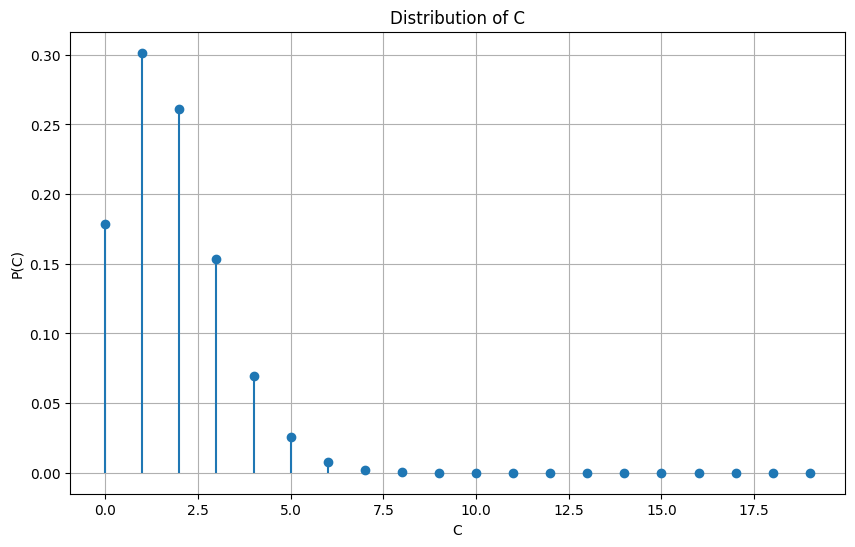

In [139]:
from scipy.special import gamma, hyp1f1, factorial

# Define the parameters
alpha = bda
beta = beta_dist_beta_h
mu1 = lambda_h
lambda1 = pg_h

# Function to compute the probability P(C = c)
def P_C(c, alpha, beta, mu1, lambda1):
    coeff = (mu1 * lambda1)**c / (factorial(c) * gamma(alpha))
    numerator = gamma(c + alpha) * gamma(alpha + beta)
    denominator = gamma(c + alpha + beta)
    hypergeom = hyp1f1(c + alpha, c + alpha + beta, -mu1 * lambda1)
    return coeff * (numerator / denominator) * hypergeom

# Compute probabilities for a range of C values
C_values = np.arange(0, 20)
P_C_values = [P_C(c, alpha, beta, mu1, lambda1) for c in C_values]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.stem(C_values, P_C_values, basefmt=" ")
plt.xlabel('C')
plt.ylabel('P(C)')
plt.title('Distribution of C')
plt.grid(True)
plt.show()

In [49]:
P_C_values

[np.float64(0.5923464451167504),
 np.float64(0.28381543375778967),
 np.float64(0.09247656167655252),
 np.float64(0.02443977183071868),
 np.float64(0.005558331416774715),
 np.float64(0.0011201094848999704),
 np.float64(0.00020357131724005144),
 np.float64(3.3772806180112536e-05),
 np.float64(5.160778090553449e-06),
 np.float64(7.315150604002229e-07),
 np.float64(9.673602700183445e-08),
 np.float64(1.1992304832048109e-08),
 np.float64(1.3994474382880922e-09),
 np.float64(1.542785868967393e-10),
 np.float64(1.611827445463332e-11),
 np.float64(1.6003377386899112e-12),
 np.float64(1.513822387489713e-13),
 np.float64(1.36738844270147e-14),
 np.float64(1.1818310016937312e-15),
 np.float64(9.792193147984697e-17)]

In [57]:
goal_probability(4, bda, beta_dist_beta_h, lambda_h, pg_h)

np.float64(0.13196986237392955)

In [58]:
(0*goal_probability(0, bda, beta_dist_beta_h, lambda_h, pg_h) + goal_probability(1, bda, beta_dist_beta_h, lambda_h, pg_h) +
 2*goal_probability(2, bda, beta_dist_beta_h, lambda_h, pg_h) + 3*goal_probability(3, bda, beta_dist_beta_h, lambda_h, pg_h)
 + 4*goal_probability(4, bda, beta_dist_beta_h, lambda_h, pg_h) + 5*goal_probability(5, bda, beta_dist_beta_h, lambda_h, pg_h))

np.float64(2.201843946093721)

In [59]:
hyper_params

{'gamma_ha': np.float64(1.256661156061415),
 'beta_dist_alpha': np.float64(18.09155851052921),
 'c': np.float64(0.02678348651050745),
 'alpha_ha': np.float64(2.7527440287281153)}

In [60]:
(pg_h*lambda_h*bda)/(bda+beta_dist_beta_h)

np.float64(2.5089267824507795)